<h1>Logistic Regression for Blood Donation Dataset from DataDriven </h1>

This workbook outline all the steps used in predicting the probability of a donor which would be donating blood in March 2007. As implied, only logistic regression is used in the following workbook with outlier removal, standard scaling, PCA for dimensional reduction and k-fold for tuning of the hyper parameters.

In [1]:
#Import required libraries for data input & exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings; 
warnings.simplefilter('ignore')

<h3> Getting/cleaning and exploratory data analysis </h3>
We will first load in the training data and reindex to donor id. Simple summary statistic is obtained and outlier detection will be carried out.

In [2]:
# Read training data set
filename = 'Warm_Up_Predict_Blood_Donations_-_Traning_Data.csv'
df = pd.read_csv(filename)

df.rename(columns={'Unnamed: 0':'Donor_Id'}, inplace=True)
df.set_index('Donor_Id', inplace=True)

In [3]:
# Setting output as category
df.iloc[:,4] = df.iloc[:,4].astype('category')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 619 to 74
Data columns (total 5 columns):
Months since Last Donation     576 non-null int64
Number of Donations            576 non-null int64
Total Volume Donated (c.c.)    576 non-null int64
Months since First Donation    576 non-null int64
Made Donation in March 2007    576 non-null category
dtypes: category(1), int64(4)
memory usage: 23.2 KB


In [5]:
df.describe()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
count,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347
std,8.175454,5.740010,1435.002556,24.227672
min,0.000000,1.000000,250.000000,2.000000
25%,2.000000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,49.250000
max,74.000000,50.000000,12500.000000,98.000000


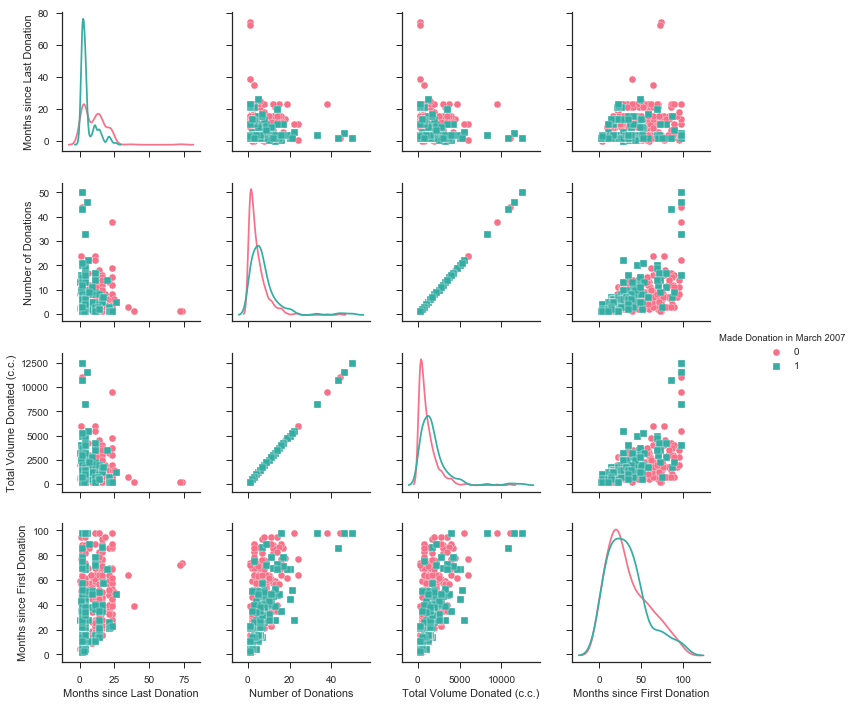

In [6]:
plt.clf()
sns.set(style="ticks")
vars_plot = ['Months since Last Donation', 'Number of Donations', 'Total Volume Donated (c.c.)',
             'Months since First Donation']
sns.pairplot(df,
             diag_kind = 'kde',
             hue="Made Donation in March 2007", vars = vars_plot, markers=["o", "s"], palette="husl")
plt.show()

Due to the strong correlation between number of donation and total volume donated (c.c) columns - the second columns would be dropped. Then outlier detection using isolation forest would be carried out to remove outlier

In [7]:
# For illus
from sklearn.ensemble import IsolationForest

# Example settings
X = df.iloc[:,[0,1,3]]
y = df.iloc[:,4]

n_samples = len(X)
rng = np.random.RandomState(295)

# Plot to show isolation forest for each variables combination
#outlier_pred = pd.DataFrame(0, index=np.arange(len(X)), columns=np.arange(1))
#outlier_pred.loc[:,'Donor_Id'] = X.index.values
#outlier_pred.set_index('Donor_Id', inplace=True)

isolation_forest = IsolationForest(max_samples=n_samples, random_state=rng, contamination=0.02)
isolation_forest.fit(X)
outlier_pred = isolation_forest.predict(X)
outlier_pred = pd.DataFrame(outlier_pred)

outlier_pred.loc[:,'Donor_Id'] = X.index.values
outlier_pred.set_index('Donor_Id', inplace=True)
len(outlier_pred[outlier_pred.iloc[:,0]==-1])

12

In [8]:
X_clean = df[outlier_pred.iloc[:,0]==1]

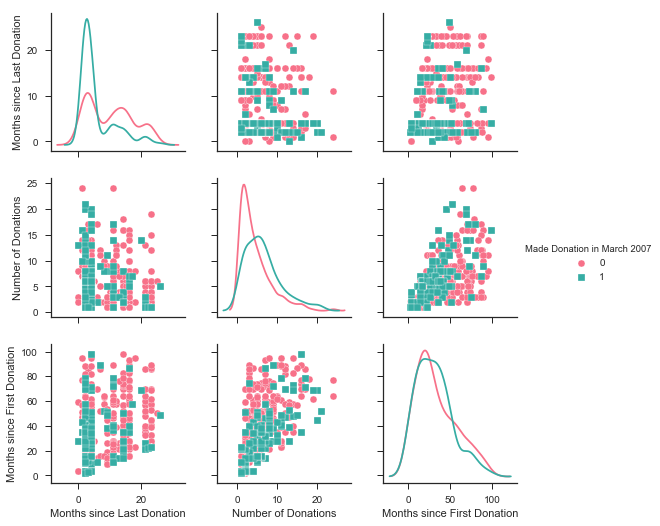

In [9]:
plt.clf()
sns.set(style="ticks")
vars_plot = ['Months since Last Donation', 'Number of Donations','Months since First Donation']
sns.pairplot(X_clean,
             diag_kind = 'kde',
             hue="Made Donation in March 2007", vars = vars_plot, markers=["o", "s"], palette="husl")
plt.show()

<h3> Simple logistic regression </h3>
Setting up simple logistic regression for original dataset (no features engineering)

In [10]:
# train simple logistic regression with no interaction variables
# To improve performance output will be normalised and scaled

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from sklearn.decomposition import PCA

In [11]:
# Preparation of X data
X = X_clean.iloc[:,[0,1,3]]
y = X_clean.iloc[:,4]

steps = [('scaler', StandardScaler()),
         ('pca', PCA()),
         ('clf', LogisticRegression())]

# Setup the hyperparameter grid
c_space = np.logspace(-2, 2, 5)
#print(c_space)
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'clf__C':c_space}
cv = GridSearchCV(pipeline, parameters, scoring='neg_log_loss', cv=5)

In [12]:
#sorted(pipeline.get_params().keys())
cv.fit(X,y)
#print(c_space)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_inter...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [13]:
print(cv.best_params_)
print(cv.best_score_)

{'clf__C': 0.10000000000000001}
-0.521589733839


<h3> Features Engineering</h3>

From dropping one columns alone, the logloss error is still at 0.51 and additional pre-processing will need to be carried out to improve the score. The following columns would be created for test

1. Frequency of blood donation (First month - last month)/donation
2. Active Duration (First month - last month)

In [14]:
#X.loc[:,'Frequency'] = (X.iloc[:,2] - X.iloc[:,0])/X.iloc[:,1]
X.loc[:,'Tenure'] = X.iloc[:,2] - X.iloc[:,0]
X.loc[:,'Dropoff'] = (X.iloc[:,2] == X.iloc[:,0]).astype('category')

In [15]:
X.head()

,Months since Last Donation,Number of Donations,Months since First Donation,Tenure,Dropoff
Donor_Id,,,,,
664,0,13,28,28,False
441,1,16,35,34,False
160,2,20,45,43,False
358,1,24,77,76,False
335,4,4,4,0,True


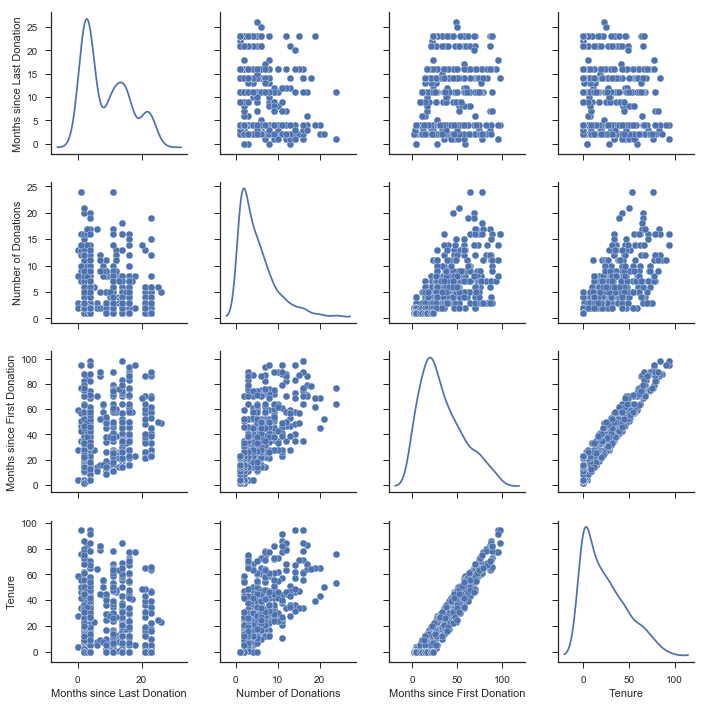

In [16]:
plt.clf()
sns.set(style="ticks")
vars_plot = ['Months since Last Donation', 'Number of Donations', 
             'Months since First Donation', 'Tenure']
sns.pairplot(X, vars = vars_plot, 
             diag_kind = 'kde', palette="husl")
plt.show()

In [32]:
# Drop month since first donation due to strong correlation with tenure
X.drop('Months since First Donation', axis=1)

,Months since Last Donation,Number of Donations,Tenure,Dropoff
Donor_Id,,,,
664,0,13,28,False
441,1,16,34,False
160,2,20,43,False
358,1,24,76,False
335,4,4,0,True
47,2,7,12,False
164,1,12,34,False
436,0,3,4,False
460,2,10,26,False


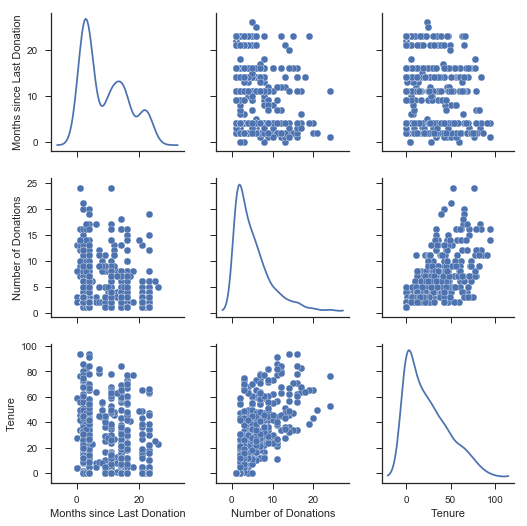

In [18]:
plt.clf()
sns.set(style="ticks")
vars_plot = ['Months since Last Donation', 'Number of Donations', 'Tenure']
sns.pairplot(X, vars = vars_plot, 
             diag_kind = 'kde', palette="husl")
plt.show()

In [41]:
X = X.drop('Months since First Donation',1)

In [42]:
cv.fit(X,y)
print(cv.best_params_)
print(cv.best_score_)

{'clf__C': 0.10000000000000001}
-0.517582886581


In [43]:
filename = 'Warm_Up_Predict_Blood_Donations_-_Test_Data.csv'
testDf = pd.read_csv(filename)

testDf.rename(columns={'Unnamed: 0':'Donor_Id'}, inplace=True)
testDf.set_index('Donor_Id', inplace=True)

In [44]:
X_test = testDf.iloc[:,[0,1,3]]
# Best prediction contain all three (0.4505)
#X_test.loc[:,'Frequency'] = (X_test.iloc[:,2] - X_test.iloc[:,0])/X_test.iloc[:,1]
X_test.loc[:,'Tenure'] = X_test.iloc[:,2] - X_test.iloc[:,0]
X_test.loc[:,'Dropoff'] = (X_test.iloc[:,2] == X_test.iloc[:,0]).astype('category')
X_test = X_test.drop('Months since First Donation', 1)

X_test['Made Donation in March 2007'] = cv.predict_proba(X_test)[:,1]

In [45]:
testOut = X_test.loc[:,'Made Donation in March 2007']
testOut.to_csv('Prediction.csv', header =True, index=True)